Statistical information on the data

In [1]:
from xml.etree import ElementTree
from xml.dom import minidom
import collections

import os

import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

In [ ]:
dataset_root = "/cluster/projects/vc/courses/TDT17/2022/open/RDD2022"

In [2]:
dataset_name = '/China_Drone/'
base_path = os.getcwd() + dataset_name

classes = {"D00": "Longitude cracks", "D10": "Lateral", "D20": "Alligator", "D40": "Pothole"}

# We ignore "Repair" and "Block crack"

imageSetsPath = os.getcwd() + '/ImageSets' + dataset_name
isExist = os.path.exists(imageSetsPath)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(imageSetsPath)
   print("The new directory is created!")

for file_name in os.listdir(imageSetsPath):
   path = imageSetsPath+file_name
   with open(path, 'w+') as f:
      f.write("")


In [3]:
# the number of total images and total labels.
cls_names = {}
total_images = 0
total_images_with_detection = 0
    
file_list = [filename for filename in os.listdir(base_path + '/train' + '/annotations/'+ "xmls/") if not filename.startswith('.')]

for file in file_list:

    total_images = total_images + 1
    if file =='.DS_Store':
        pass
    else:
        infile_xml = open(base_path + '/train' + '/annotations/' + "xmls/" + file)
        tree = ElementTree.parse(infile_xml)
        root = tree.getroot()
        image_path = root.find('filename').text.strip('.jpg')

        crack_in_image = False
        for obj in root.iter('object'):
            crack_in_image = True
            cls_name = obj.find('name').text
            path = imageSetsPath + f'/{cls_name}_images.txt'
            with open(path, 'a+') as f:
                f.write(f'{image_path}\n')
            if cls_name in cls_names.keys():
                cls_names[cls_name] += 1
            else:
                cls_names[cls_name] = 1
        if crack_in_image:
            total_images_with_detection += 1


In [4]:
print("total")
print("# of images：" + str(total_images))
print("# of labels：" + str(sum(cls_names.values())))
print('# of images with object: ' + str(total_images_with_detection))

total
# of images：2401
# of labels：3840
# of images with object: 2396


D10 : 1263
D40 : 86
D00 : 1426
Repair : 769
D20 : 293
Block crack : 3


<AxesSubplot: >

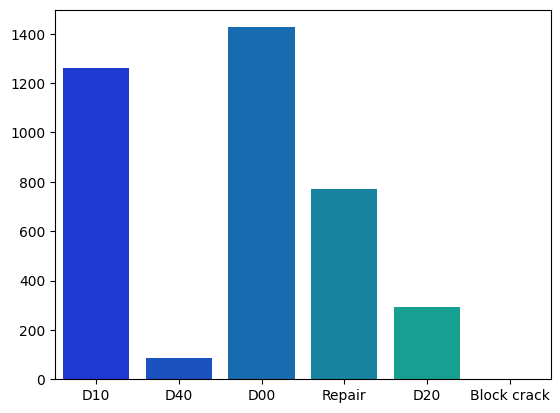

In [5]:
for cls in cls_names:
    print(str(cls) + ' : ' + str(cls_names[cls]))
sns.set_palette("winter", len(cls_names))
sns.barplot(x=list(cls_names.keys()), y= list(cls_names.values()))

# Visualize some images

In [6]:
import cv2
import random

In [7]:
def draw_images(image_file):
    gov = image_file.split('_')[0]
    img = cv2.imread(base_path + '/train'+'/images/' + image_file.split('.')[0] + '.jpg')
    
    infile_xml = open(base_path + '/train' + '/annotations/xmls/' +image_file)
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    
    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)

        font = cv2.FONT_HERSHEY_SIMPLEX

        # put text
        cv2.putText(img,cls_name,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)

        # draw bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0),3)
    return img

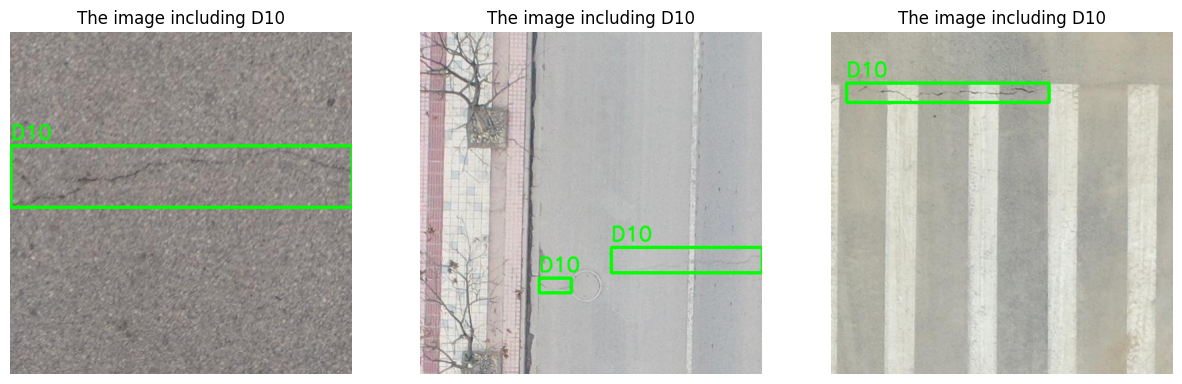

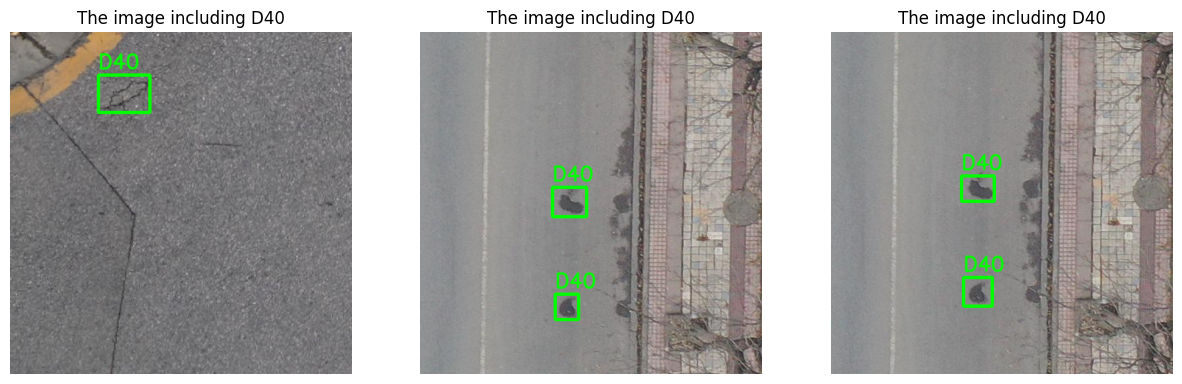

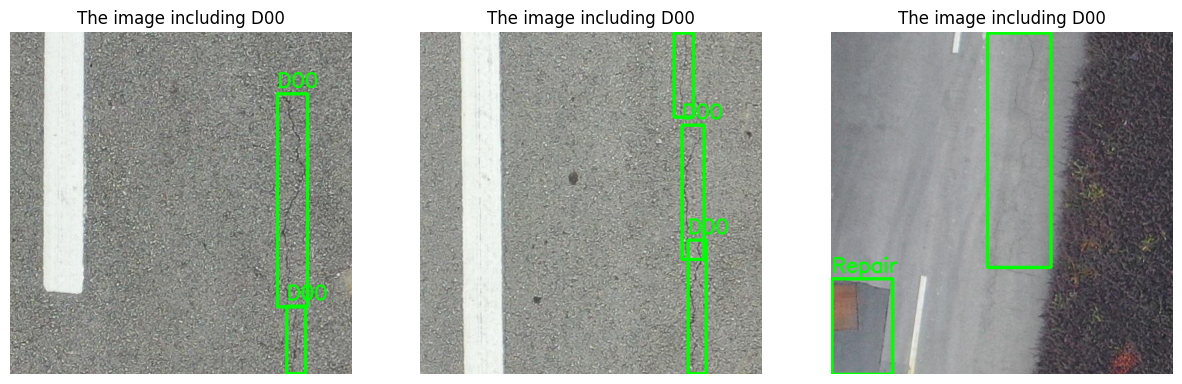

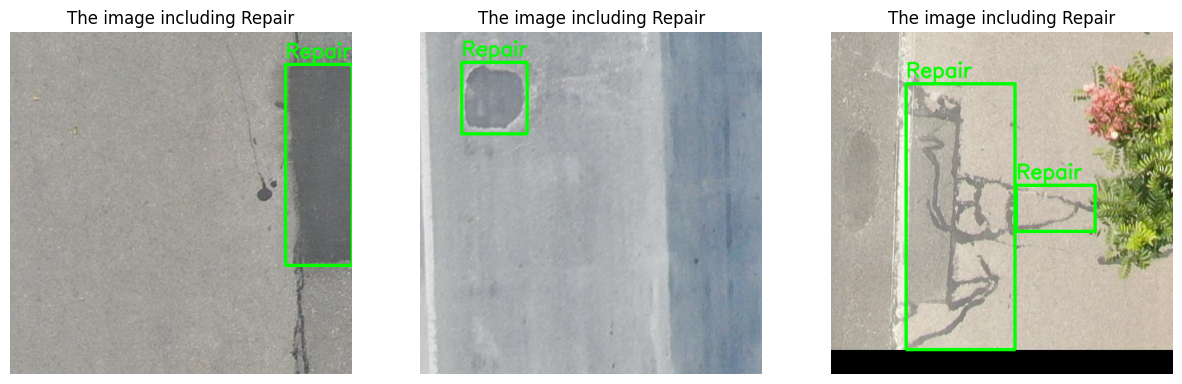

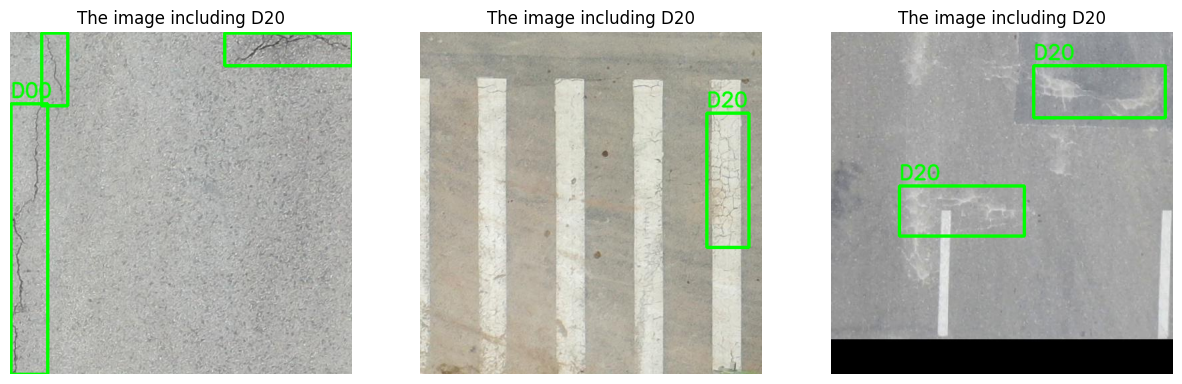

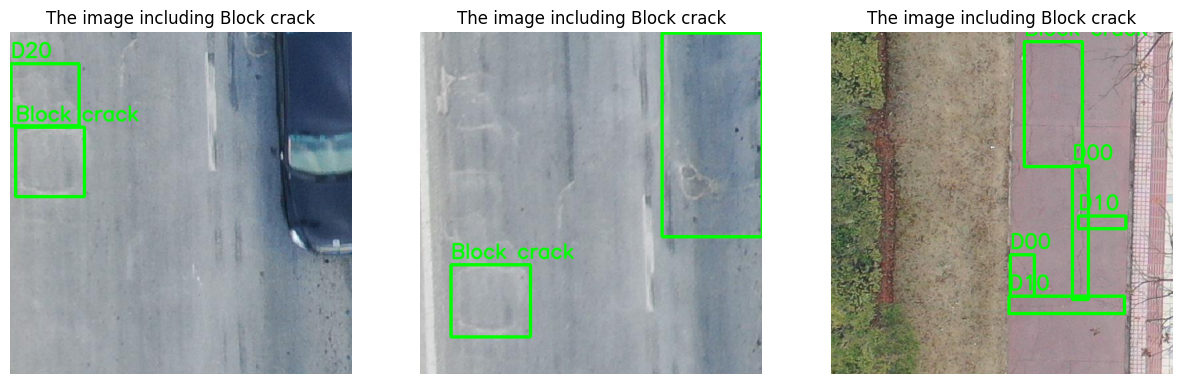

In [9]:
numb_of_images_shown = 3
for damageType in cls_names.keys():
    tmp = []

    file = open(os.getcwd()+ '/ImageSets/China_Drone/%s_images.txt' %damageType, 'r')

    for line in file:
        line = line.strip('\n')
        tmp.append(line + '.xml')
        
    random.shuffle(tmp)
    fig = plt.figure(figsize=(15,15))
    
    for number, image in enumerate(tmp[0:numb_of_images_shown]):
        img = draw_images(image)
        plt.subplot(1,numb_of_images_shown,number+1)
        plt.axis('off')
        plt.title('The image including ' + damageType)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Get all train images


# Create dataset yaml file

In [ ]:
dataset_root_dir = ""
train = ""
val = ""
classes = ["D10", "D40", "D00", "D20"]



# Convert VOC to YOLO

In [1]:
from xml2yolo import xml_to_yolo
input_dir = "China_Drone/train/annotations/xmls"
output_dir = "labels/"
image_dir = "China_Drone/train/images/"
valid_classes = ["D10", "D40", "D00", "D20"]
xml_to_yolo(input_dir, output_dir, image_dir, valid_classes)

# Model